In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.ops import nms
from torchvision.datasets import MNIST
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import os
import math

### ZF achitecture

In [2]:
class TorchZF(nn.Module):
    def __init__(self, in_channels = 1):
        """
        Initialize a ZF convolution neural network.

        Args:
            in_channels, black/white = 1, RGB = 3
        """
        super(TorchZF, self).__init__()

        self.layers = []

        # input layer
        self.convi = nn.Conv2d(1, 96, kernel_size=7, stride=2, padding = 1)
        self.relui = nn.ReLU()

        self.layers = [self.convi, self.relui]
        # hidden layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(96)
        self.conv1 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding = 1)
        self.relu1 = nn.ReLU()

        self.layers = self.layers + [self.pool1, self.norm1, self.conv1, self.relu1]

        # hidden layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.LocalResponseNorm(256)
        self.conv2 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding = 1)
        self.relu2 = nn.ReLU()

        self.layers = self.layers + [self.pool2, self.norm2, self.conv2, self.relu2]

        # hidden layer 3
        self.conv3 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding = 1)
        self.relu3 = nn.ReLU()

        self.layers = self.layers + [self.conv3, self.relu3]

        # hidden layer 4
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding = 1)
        self.relu4 = nn.ReLU()

        self.layers = self.layers + [self.conv4, self.relu4]

        # hidden layer 5
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.layers = self.layers + [self.pool5]

        # hidden layer 6
        self.flat1 = nn.Flatten()
        self.lino = nn.Linear(6*6*256, 10)
        self.softo = nn.Softmax(dim=1)

        self.layers = self.layers + [self.flat1, self.lino, self.softo]

    def forward(self, x):
        """
        Forward pass network
        """
        for layer in self.layers:
            x = layer(x)
        return x
    
def get_layers_ZF(image, params):
    model = TorchZF(in_channels = image.size()[0])
    image = image[None,:,:,:]
    image_iter = image.float().clone()

    features = []
    for layer in model.layers:
        image_iter = layer(image_iter)
        if image_iter.size()[2] < params['input_size']//params['downscale']:
            break
        features.append(layer)
        out_channels = image_iter.size()[1]

    faster_rcnn_fe_extractor = nn.Sequential(*features)
    
    return faster_rcnn_fe_extractor, out_channels

### Plotting function for image with predicted box

In [3]:
def visualize_tensor(img, gt_box, pred_box, params, save_image=''):
    """
    Now for 2D image!
    """
    plt.figure(figsize=(5,5))
    transform_img = img.permute(2,3,0,1).reshape(params['input_size'],params['input_size']).to('cpu').numpy()
    transform_img = transform_img.copy()
    for box in gt_box:
        y1, x1, y2, x2 = box
        plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2],linewidth=2)
    for box in pred_box:
        y1, x1, y2, x2 = box
        plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2],linewidth=2)
    
    if save_image == '':
        plt.imshow(transform_img, cmap='gray')
        plt.show()  
    else:
        plt.imshow(transform_img, cmap='gray')
        plt.savefig(save_image + '.png')

### Model parameters

In [4]:
params = {}
params['num_classes'] = 11  # 0-9 MNIST + background
params['input_size'] = 224
params['downscale'] = 16
params['ratios'] = [0.5, 1, 2]
params['scales'] = [4, 8, 16, 20]
params['anchor_num'] = len(params['ratios'])*len(params['scales'])
params['featuremapsize'] = 27
params['num_anchors_sample'] = 256
params['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params['RPN_lambda'] = 10
params['nms_num_train_pre'] = 4000
params['nms_num_train_post'] = 800
params['nms_num_test_pre'] = 2000
params['nms_num_test_post'] = 40
params['nms_min_size'] = 8
params['nms_threshold'] = 0.7
params['pt_n_sample'] = 128
params['pt_pos_ratio'] = 0.25
params['pt_pos_iou_threshold'] = 0.5
params['pt_neg_iou_threshold'] = 0.5
params['ROI_pooling_size'] = (5,5)
params['ROI_pooling_layer'] =  nn.AdaptiveMaxPool2d(params['ROI_pooling_size']).to(params['device'])
params['learning_rate'] = 0.00005
params['learning_epochs'] = 1

"""
TODO

Lower lambda?
Lower threshold nms, 0.5?
Lower pt_n_samples? We only have 1 box here.

""" 

### Transform MNIST

In [5]:
def get_transform(trainset, testset):
    """
    Create tuples of 3D image, label and bounding box.
    For MNIST we increase label with 1 such that we can have background!

    Args:
        trainset : tuple with list of training images and list of training labels
        testset : tuple with list of test images and list of test labels
        
    Out: 
        train_data : tuple with (3D image, labels per box, bounding boxes torch.FloatTensor([y1,x1,y2,x2]) )
        test_data : ""
        
    """
    transform = transforms.Compose([transforms.Resize((224,224))])
    train = []
    index = 0
    for i in range(len(trainset[0])//100):
        train.append(transform(trainset[0][i*100:i*100+100]))

    train = torch.stack(train).view(len(trainset[0]),224,224)

    train_data = []
    for data, label in zip(train, trainset[1]):
        train_data.append([data[None,:,:], (label+1).float(), get_box(data)])

    test = []
    for i in range(len(testset[0])//100):
        test.append(transform(testset[0][i*100:i*100+100]))

    test = torch.stack(test).view(len(testset[0]),224,224)

    test_data = []
    for data, label in zip(test, testset[1]):
        test_data.append([data[None,:,:],(label+1).float(), get_box(data)])
    
    return train_data, test_data
        
def get_box(image):
    """ 
    Generate bounding boxes for MNIST
    
    Args:
        image : 2D array
    
    Out:
        anchor : bounding box coordinates for left bottom and right top, torch.FloatTensor([y1,x1,y2,x2])
    """
    for index, y in enumerate(image):
        if y.max()>0:
            y1 = index; break

    for index, y in enumerate(reversed(image)):
        if y.max()>0:
            y2 = 224-index; break

    for index, y in enumerate(image.T):
        if y.max()>0:
            x1 = index; break

    for index, y in enumerate(reversed(image.T)):
        if y.max()>0:
            x2 = 224-index; break

    anchor = torch.FloatTensor([[y1,x1,y2,x2]])
    
    return anchor
                                  

### Create anchors for image

In [6]:
def get_anchorbase(featuremapsize, ratios, anchor_scales):
    """
    Create standard anchor base
    
    """
    anchor_base = torch.zeros(len(ratios) * len(anchor_scales), 4)
    subsample = 224/featuremapsize
    ctr_y = subsample/2.
    ctr_x = subsample/2.

    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = subsample * anchor_scales[j] * np.sqrt(ratios[i])
            w = subsample * anchor_scales[j] * np.sqrt(1./ ratios[i])

            index = i * len(anchor_scales) + j

            anchor_base[index, 0] =  - h / 2.
            anchor_base[index, 1] =  - w / 2.
            anchor_base[index, 2] =    h / 2.
            anchor_base[index, 3] =    w / 2.
    
    return anchor_base

def get_centers(featuremapsize):
    """
    Create anchor centers
    
    """
    subsample = 224/featuremapsize
    ctr_x = np.arange(subsample/2, (featuremapsize+.5) * subsample, subsample).astype(int)
    ctr_y = np.arange(subsample/2, (featuremapsize+.5) * subsample, subsample).astype(int)
    return ctr_x, ctr_y

def generate_anchors(model_params):
    """
    Generate anchors for images
    
    Args:
        Model parameters dictionary 
        
    Out: 
        Anchors for image
    """
    ctr_x, ctr_y = get_centers(model_params['featuremapsize'])
    anchors = torch.zeros(len(ctr_x) * len(ctr_y) * model_params['anchor_num'], 4)
    anchor_base = get_anchorbase(model_params['featuremapsize'], model_params['ratios'], model_params['scales'])
    index = 0
    for x in ctr_x:
        for y in ctr_y:
            xy = torch.FloatTensor([y,x,y,x])
            anchors[index:index + model_params['anchor_num'],:] = anchor_base + xy
            index += model_params['anchor_num']
    return anchors

def get_valid_anchors(anchors):
    """
    Keep boxes within image size
    
    Args:
        anchors : all anchors for image in N x 4 array
        
    Out: 
        valid_anchors_poses : array with valid anchor positions in anchors
        val_anchors : all valid anchors for image in N* x 4 array
    """

    valid_anchors_poses = torch.where(((anchors.T[0]>=0) & (anchors.T[1]>=0) &
         (anchors.T[2]<=224) & (anchors.T[3]<=224)))[0]
    val_anchors = anchors[valid_anchors_poses,:].clone()
    
    return valid_anchors_poses, val_anchors

### Find Intersection Over Union

In [7]:
def get_iou(valid_anchors, gt_boxes):
    ious = torch.zeros((valid_anchors.shape[0], len(gt_boxes)))
    for indexa, xya in enumerate(valid_anchors):
        ya1, xa1, ya2, xa2 = xya
        anchor_area = (ya2 - ya1) * (xa2 - xa1)
        for indexb, xyb in enumerate(gt_boxes):
            yb1, xb1, yb2, xb2 = xyb
            box_area = (yb2- yb1) * (xb2 - xb1)
            inter_x1 = max([xb1, xa1])
            inter_y1 = max([yb1, ya1])
            inter_x2 = min([xb2, xa2])
            inter_y2 = min([yb2, ya2])
            if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                iou = inter_area / (anchor_area + box_area - inter_area)
            else: 
                iou = 0
            ious[indexa, indexb] = iou
    return ious

### RCNN paper : sample train samples from max_iou data

In [8]:
def get_max_iou_data(iou_matrix):
    """
    Out:
        all_gt_max : all positions which have maximum value with a ground truth box
        anchor_max_value : maximal iou values for each anchor over all gt boxes
        anchor_max : gt true box corresponding to anchor_max_values
    """
    gt_max_value = iou_matrix.max(axis=0)[0] #  for each gt box, this is the max iou
    
    #There is a possiblilty that corresponding to one gt box, there are multiple anchors with same iou (max value)
    all_gt_max = torch.where(iou_matrix == gt_max_value)[0]
    
    # For each anchor box, this is the max iou with any of the gt_box
    anchor_max_value = torch.max(iou_matrix, axis=1)[0]
    anchor_max = torch.argmax(iou_matrix, axis=1)
    
    return all_gt_max, anchor_max_value, anchor_max

def get_anchor_labels(anchor_positions, all_gt_max, anchor_max_value):
    """
    Out:
        anchor_labels 1 - positive || 0 - negative || -1 - ignore
    """
    anchor_labels = torch.zeros(anchor_positions.shape[0])
    anchor_labels.fill_(-1.0)

    # for each anchor box, if iou with any of the gt_box is less than threshold, mark as 0
    anchor_labels[anchor_max_value < 0.3] = 0
    
    # If corresponding to any gt_box, the anchor has max iou -> mark as 1
    anchor_labels[all_gt_max] = 1.0
    
    # If for any anchor box, iou is greater than threshold for any of the gt_box, mark as 1
    anchor_labels[anchor_max_value > 0.7] = 1.0
    return anchor_labels

def sample_anchors_for_train(anchor_labels, params):
    """
    randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where
    the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer 
    than 128 positive samples in an image, we pad the mini-batch with negative ones.
    """
    
    pos_anchor_labels = torch.where(anchor_labels == 1)[0]
    num_pos = min(params['num_anchors_sample']/2, len(pos_anchor_labels))
    pos_idx = np.random.choice(pos_anchor_labels,  int(num_pos), replace=False)

    neg_anchor_labels = torch.where(anchor_labels == 0)[0]
    num_neg = params['num_anchors_sample'] - num_pos
    neg_idx = np.random.choice(neg_anchor_labels, int(num_neg), replace=False)
    
    anchor_labels[:] = -1
    anchor_labels[pos_idx] = 1
    anchor_labels[neg_idx] = 0
    
    return anchor_labels

### Parameterize anchor boxes with respect to ground truth boxes for regression

In [32]:
"""
Parameterization:
    dx = (x - x_{a})/w_{a}
    dy = (y - y_{a})/h_{a}
    dw = log(w/ w_a)
    dh = log(h/ h_a)
"""

def get_delta_anchors(anchor_positions, gt_boxes , anchor_max):
    """
    Args: 
        anchor_positions : valid anchor positions N* x 4
        gt_boxes : torch tensor with ground truth boxes (y1,x1,y2,x2)
        anchor_max : tensor indicating to which gt_box each valid anchor corresponds
        
    Out:
        parameterized delta between valid anchors and ground truth boxes
    """
 
    anchor_gt_map =  gt_boxes[anchor_max]
    
    anchor_height = anchor_positions[:,2] - anchor_positions[:,0] # y2-y1
    anchor_width =  anchor_positions[:,3] - anchor_positions[:,1] # x2-x1
    anchor_ctr_y = anchor_positions[:,0] + anchor_height/2 # y1 + h/2
    anchor_ctr_x = anchor_positions[:,1] + anchor_width/2  # x1 + w/2
    
    gt_height = anchor_gt_map[:,2] - anchor_gt_map[:,0] # y2-y1
    gt_width =  anchor_gt_map[:,3] - anchor_gt_map[:,1] # x2-x1
    gt_ctr_y = anchor_gt_map[:,0] + gt_height/2 # y1 + h/2
    gt_ctr_x = anchor_gt_map[:,1] + gt_width/2  # x1 + w/2
    
    dx = (gt_ctr_x - anchor_ctr_x)/anchor_width
    dy = (gt_ctr_y - anchor_ctr_y)/anchor_height
    dw = torch.log(gt_width/anchor_width)
    dh = torch.log(gt_height/anchor_height)
    
    delta = torch.zeros_like(anchor_positions)
    delta[:,0] = dx
    delta[:,1] = dy
    delta[:,2] = dw
    delta[:,3] = dh
   
    return delta


# Given delta and anchor_positions, correct the anchors
def correct_anchor_positions(anchor_positions, delta):
    ha = anchor_positions[:,2] - anchor_positions[:,0] # y2-y1
    wa =  anchor_positions[:,3] - anchor_positions[:,1] # x2-x1
    ya = anchor_positions[:,0] + ha/2 # y1 + h/2
    xa = anchor_positions[:,1] + wa/2  # x1 + w/2
    
    dx = delta[:,0]
    dy = delta[:,1]
    dw = delta[:,2]
    dh = delta[:,3]
    
    
    x = dx*wa + xa
    y = dy*ha + ya
    w = torch.exp(dw)*wa
    h = torch.exp(dh)*ha
    
    correct_anchor_positions = torch.zeros_like(anchor_positions)
    
    correct_anchor_positions[:,1] = x - w/2
    correct_anchor_positions[:,3] = x + w/2
    correct_anchor_positions[:,0] = y - h/2
    correct_anchor_positions[:,2] = y + h/2
    
    return correct_anchor_positions   

### Faster RCNN RPN network : combine ZF with output RPN classifier and regression layer

In [10]:
class Faster_RCNN_rpn(nn.Module):

    
    def __init__(self, extracter, extracter_out_channels, params):
        """
        Torch region proposal network
            Class layer : checks for all anchors object or no object
            Regression layer : checks delta with respect to ground truth

        Args:
            extracter : cutted ZF network from get_layers_ZF()
            extracter_out_channels : channel depth from extracter
            pararms : model parameter dictionary

        """
        super(Faster_RCNN_rpn, self).__init__()
        
        self.extracter = extracter
        self.conv1 = nn.Conv2d(in_channels = extracter_out_channels, out_channels = extracter_out_channels,
                               kernel_size = 3, stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.reg_layer = nn.Conv2d(in_channels = extracter_out_channels, out_channels = params['anchor_num'] *4,
                                   kernel_size = 1, stride = 1, padding = 0)
        self.cls_layer = nn.Conv2d(in_channels = extracter_out_channels, out_channels = params['anchor_num'] *2, 
                                   kernel_size = 1, stride = 1, padding = 0)
        
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()    
        
    def forward(self,x):
        extracter_out = self.extracter(x)
        conv_out = self.relu(self.conv1(extracter_out))
        class_out = self.cls_layer(conv_out)
        reg_out = self.reg_layer(conv_out)
        
        return extracter_out, class_out, reg_out

### Loss function RPN classifier + regressor

In [11]:
def RPN_loss(locs_predict, class_predict, final_RPN_locs, final_RPN_class, params):
    """
    Check between foreground and background for classes, ignore -1. 
    Smooth L1 regression loss in predicted locations of foreground. Add losses with lambda
    
    Args:
        locs_predict : predicted anchor values
        class_predict : predicted anchor background/foreground (0/1)
        final_RPN_locs : parameterized anchor locations (delta) for valid anchor locations
        final_RPN_class : all labels of which 256 are (0/1) 
        params : model parameters
        
    Out:
        rpn_loss : classification + regression loss
    """
    
    final_RPN_locs = final_RPN_locs.to(params['device'])
    final_RPN_class = final_RPN_class.long().to(params['device'])

    class_loss = nn.functional.cross_entropy(class_predict, final_RPN_class, ignore_index=-1)

    foreground_class_idx = (final_RPN_class > 0)  # foreground samples
    locs_predict  = locs_predict[foreground_class_idx]  # update predicted regression samples
    final_RPN_locs = final_RPN_locs[foreground_class_idx]  # update true regression samples

    loc_loss = nn.functional.smooth_l1_loss(locs_predict, final_RPN_locs) / (sum(foreground_class_idx)+1e-6)
    
    rpn_loss = class_loss + params['RPN_lambda']*loc_loss  # weight regression loss with lambda
  
    return rpn_loss

### Non maximum suppression (Pytorch implementation)

In [12]:
def non_max_suppression(correct_anchor_positions, class_score, isTrain, params):
    """
    Non maximum suppression. Use all anchors, clip to image dimension. 
    Only keep anchors with minimal width and height > nms_min_size
    
    Args:
        correct_anchor_positions : 
        class_score : Score for classification from decider layer
        isTrain : True when training, False when testing
        params : model parameters
    """
    
    if isTrain:
        nms_pre = params['nms_num_train_pre']
        nms_post = params['nms_num_train_post']
    else :
        nms_pre = params['nms_num_test_pre']
        nms_post = params['nms_num_test_post']
        
    # Clip the anchors to image dimensions
    correct_anchor_positions[correct_anchor_positions[:,1] < 0, 1] = 0 # x1
    correct_anchor_positions[correct_anchor_positions[:,3] > params['input_size'], 3] = params['input_size'] # x2
    correct_anchor_positions[correct_anchor_positions[:,0] < 0, 0] = 0 # y1
    correct_anchor_positions[correct_anchor_positions[:,2] > params['input_size'], 2] = params['input_size'] # y2
        
    # Only keep anchors with height and width > nms_min_size
    anchor_width = correct_anchor_positions[:,3] - correct_anchor_positions[:,1]
    anchor_height = correct_anchor_positions[:,2] - correct_anchor_positions[:,0]
    
    keep_idx = (anchor_height > params['nms_min_size']) & (anchor_width > params['nms_min_size'])
    correct_anchor_positions = correct_anchor_positions[keep_idx]
    class_score = class_score[keep_idx]

    # Get the index of sorted class scores in descending order and select top nms_pre idx
    sorted_class_scores = torch.argsort(class_score, descending=True)
    pre_nms_idx = sorted_class_scores[:nms_pre]  # only keep top nms_pre
    correct_anchor_positions = correct_anchor_positions[pre_nms_idx]
    class_score = class_score[pre_nms_idx]
    
    # Necessary for Pytorch
    change_format = torch.zeros_like(correct_anchor_positions)
    change_format[:,0] = correct_anchor_positions[:,1]
    change_format[:,1] = correct_anchor_positions[:,0]
    change_format[:,2] = correct_anchor_positions[:,3]
    change_format[:,3] = correct_anchor_positions[:,2]

    # from torchvision.ops import nms
    keep_anchors = nms(change_format.to('cpu'), class_score.clone().detach().to('cpu'), 
                                       params['nms_threshold'])

    keep_anchors = keep_anchors[:nms_post]
    correct_anchor_positions = correct_anchor_positions[keep_anchors]
    
    return correct_anchor_positions

### Assign class labels to output of RPN network (regions of interest ROI) for decider network

In [13]:
def assign_classification_anchors(extracted_roi, gt_boxes, gt_labels, isTrain, params):

    """ 
    We are now assigning the real image labels (for MNIST 0-9)
    
    Args:
        extracted_roi : regions of interest from nms
        gt_boxes : ground truth bounding boxes (y1,x1,y2,x2)
        gt_labels : labels of ground truth bounding boxes
        isTrain : for training True, for testing False
        params : model parameters
        
        """
    
    # calculate iou of rois and gt boxes
    iou_matrix = get_iou(extracted_roi, gt_boxes)
    
    # for each ROI, find gt with max iou and corresponding value
    gt_roi_argmax = iou_matrix.argmax(axis=1)
    gt_roi_max = iou_matrix.max(axis=1)[0]
    
    #If a particular ROI has max overlap with a gt_box, assign label of gt_box to roi
    assign_labels = gt_labels[gt_roi_argmax]
    
    num_pos = params['pt_n_sample']*params['pt_pos_ratio']
    pos_idx = torch.where(gt_roi_max > params['pt_pos_iou_threshold'])[0]
    
    if isTrain:
        pos_idx = np.random.choice(pos_idx, int(min(len(pos_idx), num_pos)), replace=False)
       
    num_neg = params['pt_n_sample'] - len(pos_idx)
    neg_idx = torch.where(gt_roi_max < params['pt_neg_iou_threshold'])[0]
    if isTrain:
        neg_idx = np.random.choice(neg_idx, int(min(len(neg_idx), num_neg)), replace=False)
       
    keep_idx = np.append(pos_idx, neg_idx)
    assign_labels[neg_idx] = 0
    assign_labels = assign_labels[keep_idx]
    extracted_roi = extracted_roi[keep_idx]
    gt_roi_argmax = gt_roi_argmax[keep_idx]
    
    return assign_labels, extracted_roi, gt_roi_argmax, keep_idx

### Do max pooling on ROI to reduce channel dimensions

In [14]:
def ROI_pooling(extracted_roi, feature, params):
    """
    Pooling of found regions of interest with kernel size (params['ROI_pooling_size'])
    
    Args:
        extracted_roi : extracted regions of interest in terms of (y1,x1,y2,x2) from RPN
        feature : image out of convolutional RPN layer, rescale roi with subsample ratio
        params : model parameters
    """
    
    subsample = params['input_size']/params['featuremapsize']
    extracted_roi = extracted_roi/subsample
    out = []
    
    for roi in extracted_roi:
        
        y1 = int(roi[0])
        x1 = int(roi[1])
        y2 = int(roi[2]+1)
        x2 = int(roi[3]+1)
        out.append(params['ROI_pooling_layer'](feature[:,:,y1:y2,x1:x2]))
    out = torch.cat(out)
    return out

### Faster RCNN decider network - classification and regression layer

In [15]:
class Faster_RCNN_decider(nn.Module):
    """
    Torch decider network :  
        classidier : standard ZFNet classifier layer
        class_lin : dense layer for object classification (ex. MNIST 0-9)
        reg_lin : dense layer for regression of bounding boxes
        
    Args:
        in_features : out size of flatten layer, (pooling_size**2) * (out_channels zfnet)
        params : model parameters for number of classes
    """
    
    def __init__(self, in_features, params):
        super(Faster_RCNN_decider, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier_lin = nn.Linear(in_features=in_features, out_features=2048, bias=True)
        self.relu = nn.ReLU()
        self.classifier_dropout = nn.Dropout(p=.5, inplace = False)
        self.class_lin = nn.Linear(2048, params['num_classes'])
        self.reg_lin = nn.Linear(2048, params['num_classes']*4)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.classifier_lin(x))
        x = self.classifier_dropout(x)
        decider_class = self.class_lin(x)
        decider_loc = self.reg_lin(x)
        
        return decider_class, decider_loc
    

### Single image pipeline

In [16]:
def single_image_pipeline(input_image, gt_box, label, rpn, decider, img_anchors_all, isTrain, params):
    """
    Single pipeline for an image eventually used in training.
    
    Args:
        input_image : 4D image? (batch, channels, width, height)
        gt_box : ground truth (y1,x1,y2,x2)
        label : label (0-9 MNIST)
        rpn : rcnn rpn initialized network
        decider : rcnn decider initialized network
        img_anchors_all : standard anchors for input image
        isTrain : training True, testing False
        params : model parameters
    """
    device = params['device']
    
    # Set to device (float tensor already done for MNIST)
    input_image = input_image.to(params['device'])
    gt_box = torch.FloatTensor(gt_box).to(params['device'])
    label = torch.FloatTensor(label).to(params['device'])

    # Generate CNN features for input image
    # Genearate region proposals predictions
    features, class_out, reg_out = rpn(input_image)

    # set channel size to last dimension (number of different anchors)
    # concatenate all vectors underneath each other with columns classes or bb positions
    locs_predict = reg_out.permute(0,2,3,1).reshape(1,-1,4)[0]
    class_predict = class_out.permute(0,2,3,1).reshape(1,-1,2)[0]
    
    # one row of class scores?
    class_score = class_out.reshape(1,features.shape[2],features.shape[3],params['anchor_num'],2)[:,:,:,:,1].reshape(1,-1)[0].detach()

     
    # For training region proposal network, generate anchors on the image. 
    img_anchors_valid_idx, img_anchors_valid = get_valid_anchors(img_anchors_all.clone())

    # intersection over union for gt boxes and valid anchors
    iou_anchors_gt = get_iou(img_anchors_valid, gt_box)
    # all_gt_max : all positions which have maximum value with a ground truth box
    # anchor_max_value : maximal iou values for each anchor over all gt boxes
    # anchor_max : gt true box corresponding to anchor_max_values
    all_gt_max, anchor_max_value, anchor_max = get_max_iou_data(iou_anchors_gt)
    
    # anchor_labels 1 - positive || 0 - negative || -1 - ignore
    anchor_labels = get_anchor_labels(img_anchors_valid, all_gt_max, anchor_max_value)
    # sample only 256 anchor positions from positive and negative
    anchor_labels = sample_anchors_for_train(anchor_labels, params)
    
    # find parameterized deltas with gt boxes
    delta = get_delta_anchors(img_anchors_valid, gt_box, anchor_max)
    
    # found deltas as nonzeros
    final_RPN_locs = torch.zeros_like(img_anchors_all)
    final_RPN_locs[img_anchors_valid_idx] = delta

    # found foreground and background (256) as 0 or 1
    final_RPN_class = torch.zeros(img_anchors_all.shape[0])
    final_RPN_class.fill_(-1)
    final_RPN_class[img_anchors_valid_idx] = anchor_labels

    # Loss for RPN layer, predict is through layer, final is compared to gt
    loss1 = RPN_loss(locs_predict, class_predict, final_RPN_locs, final_RPN_class, params).to(device)
    
    # Based on the bbox output of rpn, correct the generated anchors (locs_predict is delta)
    corrected_anchors = correct_anchor_positions(img_anchors_all.to(device), locs_predict).detach()
 
    
    # Apply nms on the region proposals
    extracted_rois = non_max_suppression(corrected_anchors, class_score, isTrain, params)

    # assign ground truth labels to anchors
    final_decider_class, extracted_roi_samples, gt_roi_argmax, idx = assign_classification_anchors(extracted_rois, gt_box, label, isTrain, params)

    final_decider_locs = get_delta_anchors(extracted_roi_samples, gt_box, gt_roi_argmax)
   
    # Apply ROI pooling on the extracted ROIs
    pooled_features = ROI_pooling(extracted_roi_samples, features, params)

    # do decider network pass
    decider_class, decider_loc = decider(pooled_features)
    decider_loc = decider_loc.reshape(pooled_features.shape[0],-1,4) # 128*21*4
    decider_loc = decider_loc[torch.arange(0,pooled_features.shape[0]), final_decider_class.long()] # 128*4
    
    # Loss for decider layer
    loss2 = RPN_loss(decider_loc, decider_class, final_decider_locs, final_decider_class, params).to(device)
    
    with torch.no_grad():
        decider_loc_no_grad = decider_loc.clone().to(device)

    # Correct the ROIs based on bbox output for decider layers
    corrected_roi = correct_anchor_positions(extracted_roi_samples, decider_loc_no_grad).detach()
    
    return loss1, loss2 , decider_class, corrected_roi

### Test model

In [1]:
def test_model(input_image, rpn, decider, params):
    rpn.eval()
    decider.eval()

    device = params['device']
    
    input_image = input_image.to(device)
    features, class_out, reg_out = rpn(input_image)
    locs_preditct = reg_out.permute(0,2,3,1).reshape(1,-1,4)[0]
    class_score = class_out.reshape(1,features.shape[2],features.shape[3],params['anchor_num'],2)[:,:,:,:,1].reshape(1,-1)[0].detach()

    corrected_anchors = correct_anchor_positions(img_anchors_all.to(device), locs_preditct).detach()


    extracted_rois = non_max_suppression(corrected_anchors, class_score, False, params)


    pooled_features = ROI_pooling(extracted_rois, features, params)

    decider_class, decider_loc = decider(pooled_features)

    with torch.no_grad():
        decider_loc_no_grad = decider_loc.clone().to(device)

    corrected_roi = correct_anchor_positions(extracted_rois,decider_loc_no_grad).detach()
    corrected_roi[corrected_roi[:,1] < 0, 1] = 0 # x1
    corrected_roi[corrected_roi[:,3] > params['input_size'], 3] = params['input_size'] # x2
    corrected_roi[corrected_roi[:,0] < 0, 0] = 0 # y1
    corrected_roi[corrected_roi[:,2] > params['input_size'], 2] = params['input_size'] # y2

    decoder_conf = decider_class.softmax(dim=1).max(dim=1)[0]
    decoder_conf = decoder_conf.detach()
    decoder_conf = decoder_conf[decider_class.argmax(axis=1) != 0]


    keep_anchors = []
    sorted_class_scores = torch.argsort(decoder_conf, descending=True)

    while len(sorted_class_scores) > 1:
        current = sorted_class_scores[0]
        keep_anchors.append(current.item())
        iou_matrix = get_iou(corrected_roi[sorted_class_scores[1:]],corrected_roi[current].reshape(1,-1,4)[0])
        sorted_class_scores = sorted_class_scores[np.where(iou_matrix < 0.2)[0] + 1]

    if (len(sorted_class_scores) == 1):
        keep_anchors.append(sorted_class_scores[0].item())

    for pred in decider_class.argmax(axis=1)[decider_class.argmax(axis=1) != 0][keep_anchors]:
        print(val_to_lab[int(pred)], end=', ')
    print('')

    for pred in decoder_conf[keep_anchors]:
        print(pred.item(), end=', ')

    visualize_tensor(input_image, extracted_rois[decider_class.argmax(axis=1) != 0][keep_anchors], [], params)

### Load MNIST data, transform to 224 x 224 and create bounding boxes

In [27]:
"""
train_sample:
    dim 0 : tensor image : 1 x 224 x 224
    dim 1 : tensor label : 1 x #(gt_boxes)
    dim 2 : tensor bounding boxes : N x 4
"""

mnist_train_img, mnist_train_lab = torch.load('data/MNIST/processed/training.pt')
mnist_test_img, mnist_test_lab = torch.load('data/MNIST/processed/test.pt')
train_sample = (mnist_train_img[:1000], mnist_train_lab[:1000])
test_sample = (mnist_test_img[:100], mnist_test_lab[:100])
train_data, test_data = get_transform(train_sample, test_sample)

val_data = train_data[850:]
train_data = train_data[:850]

lab_to_val = {j:i+1 for i,j in enumerate(np.arange(0,10))}
val_to_lab = {i+1:j for i,j in enumerate(np.arange(0,10))}

### Initialize for training

In [18]:
loss1_hist = []
loss2_hist = []
loss_hist = []
valid_loss1_hist = []
valid_loss2_hist = []
valid_loss_hist = []
epoch_start = 0
best_valid_score = 10000

# Extract neceassary ZFNet layers for output image size for dummy training image s.t. size < 224//16
zf_feature_extracter, extracter_out_channels = get_layers_ZF(train_data[0][0], params)

# Initialize rpn network based on number of out_channels
rpn = Faster_RCNN_rpn(zf_feature_extracter, extracter_out_channels, params).to(params['device'])

# Generate standard anchors which can be used for every input image
img_anchors_all = generate_anchors(params).to(params['device']) 

# Intialize decider network based on size pooled regions of interest
decider_in_channels = params['ROI_pooling_size'][0]*params['ROI_pooling_size'][1]*extracter_out_channels
decider = Faster_RCNN_decider(decider_in_channels, params).to(params['device']) 

# List parameters
all_params = list(list(rpn.parameters()) + list(decider.parameters()))

# Adam optimizer
optimizer = optim.Adam(all_params, lr=params['learning_rate'])

# some parameters?
running_count = 0
running_net_loss = 0
running_loss1 = 0
running_loss2 = 0
loss_avg_step = 20
train_visualise_step = 150

### Show example

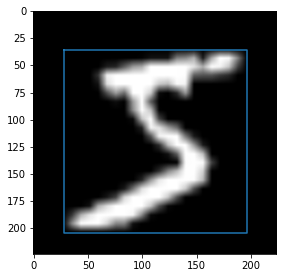

In [19]:
plt.figure(figsize=(4,4))
plt.imshow(train_data[0][0].squeeze(), cmap='gray')
a = train_data[0][2][0]
x = [a[1], a[3], a[3], a[1], a[1]]
y = [a[0], a[0], a[2], a[2], a[0]]
plt.plot(x,y)
plt.tight_layout()

### Training RCNN

Start epoch - 0
best_valid_score - 10000
0--19--- tensor(21.6551, device='cuda:0')
0--39--- tensor(9.6613, device='cuda:0')
0--59--- tensor(5.7537, device='cuda:0')
0--79--- tensor(4.2300, device='cuda:0')
0--99--- tensor(2.3107, device='cuda:0')
0--119--- tensor(1.7032, device='cuda:0')
0--139--- tensor(1.6107, device='cuda:0')
Train Data Visualise


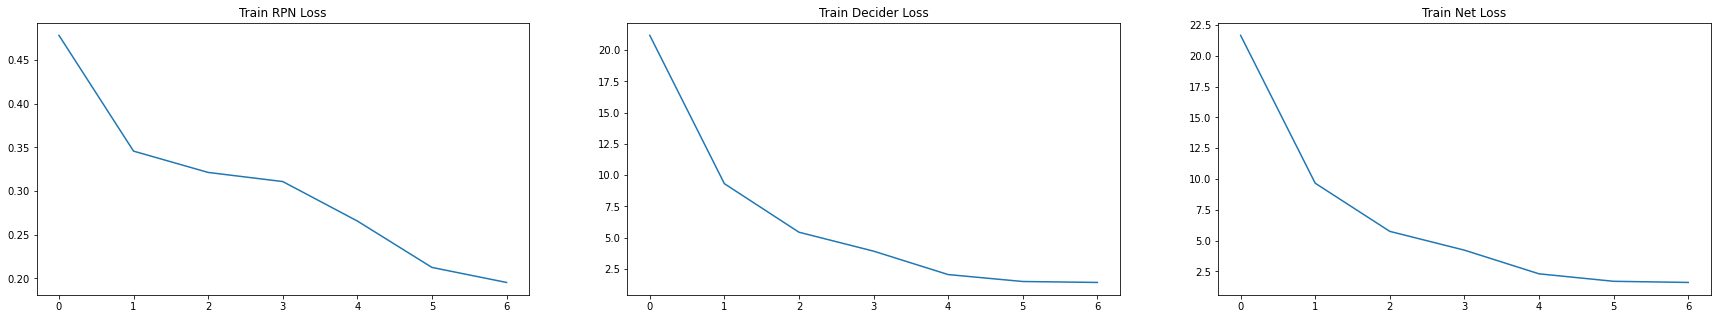

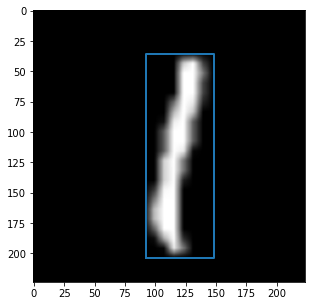


0--159--- tensor(1.7166, device='cuda:0')
0--179--- tensor(1.0983, device='cuda:0')
0--199--- tensor(0.8907, device='cuda:0')
0--219--- tensor(1.3517, device='cuda:0')
0--239--- tensor(0.5941, device='cuda:0')
0--259--- tensor(0.6960, device='cuda:0')
0--279--- tensor(0.5252, device='cuda:0')
0--299--- tensor(0.5071, device='cuda:0')
Train Data Visualise


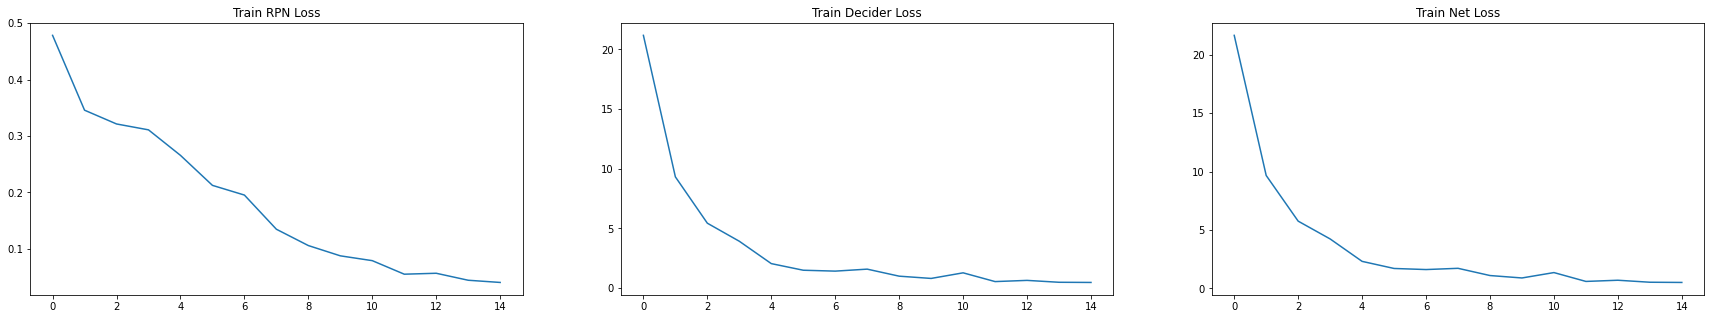

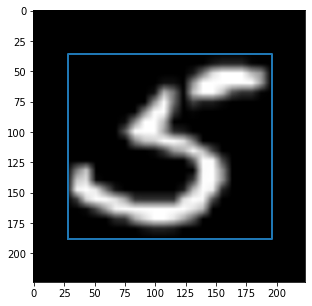


0--319--- tensor(0.5368, device='cuda:0')
0--339--- tensor(0.4449, device='cuda:0')
0--359--- tensor(0.5476, device='cuda:0')
0--379--- tensor(0.6741, device='cuda:0')
0--399--- tensor(0.4387, device='cuda:0')
0--419--- tensor(0.4377, device='cuda:0')
0--439--- tensor(0.5207, device='cuda:0')
Train Data Visualise


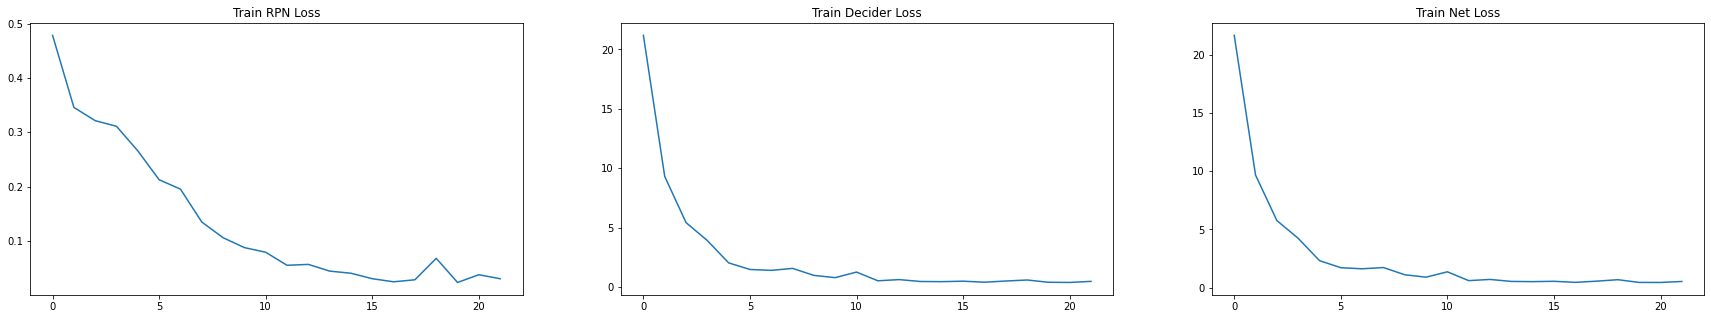

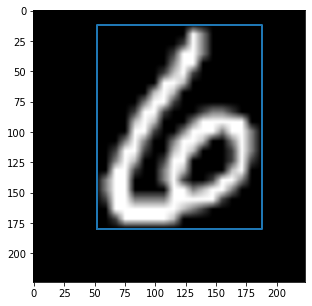


0--459--- tensor(0.3654, device='cuda:0')
0--479--- tensor(0.3485, device='cuda:0')
0--499--- tensor(0.3336, device='cuda:0')
0--519--- tensor(0.3821, device='cuda:0')
0--539--- tensor(0.3769, device='cuda:0')
0--559--- tensor(0.3955, device='cuda:0')
0--579--- tensor(0.3058, device='cuda:0')
0--599--- tensor(0.3105, device='cuda:0')
Train Data Visualise


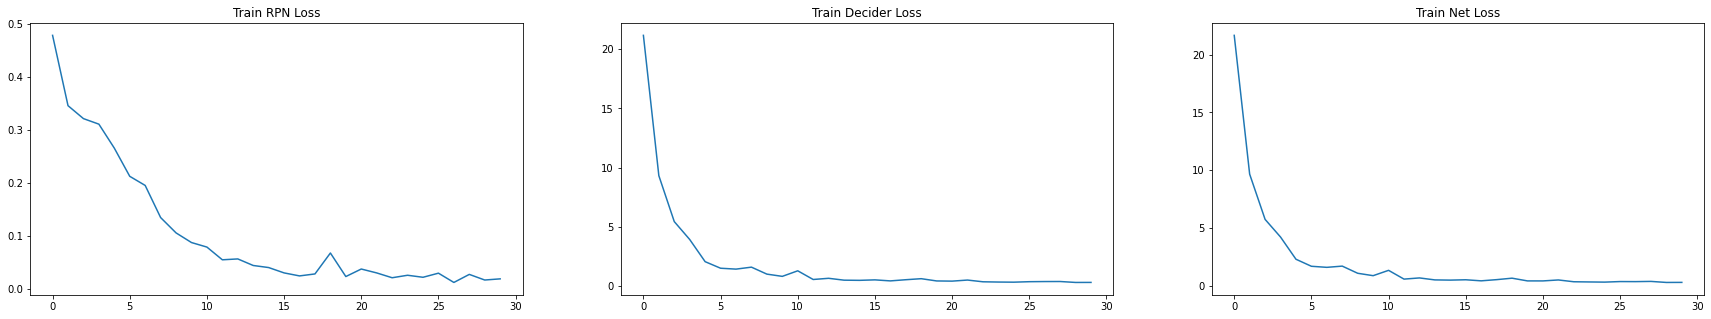

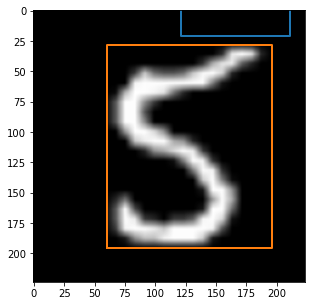

NameError: name 'val_to_lab' is not defined

In [20]:
print("Start epoch - " + str(epoch_start))
print("best_valid_score - " + str(best_valid_score))
for epoch in range(epoch_start, epoch_start + params['learning_epochs']):
    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    
    # loop over loader, start at 0
    for i, data in enumerate(train_loader, 0):

        img, labels, gt_box = data
        gt_box = gt_box.reshape(-1,4)
        img = img.float()

        loss1, loss2, pred_class, pred_box = single_image_pipeline(img, gt_box, labels, rpn, decider,
                                                                   img_anchors_all, True, params)
        net_loss = loss1 + loss2

        optimizer.zero_grad()
        net_loss.backward()
        optimizer.step()

        loss1 = loss1.detach()
        loss2 = loss2.detach()
        pred_class = pred_class.detach()
        pred_box = pred_box.detach()
        net_loss = net_loss.detach()
        if not((math.isnan(net_loss)) or (math.isnan(loss1)) or (math.isnan(loss2))):
            running_count += 1
            running_net_loss += net_loss.data
            running_loss1 += loss1.data
            running_loss2 += loss2.data

        
        if ((i+1)%(loss_avg_step) == 0):
            loss1_hist.append(running_loss1/(running_count + 1e-6))
            loss2_hist.append(running_loss2/(running_count + 1e-6))
            loss_hist.append(running_net_loss/(running_count + 1e-6))
            print(str(epoch) + '--' + str(i) + '--- ' + str(running_net_loss/(running_count + 1e-6)))
            running_count = 0
            running_net_loss = 0
            running_loss1 = 0
            running_loss2 = 0


        if ((i+1)%(train_visualise_step)) == 0:
            print("Train Data Visualise")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
            ax1.plot(loss1_hist)
            ax1.title.set_text('Train RPN Loss')
            ax2.plot(loss2_hist)
            ax2.title.set_text('Train Decider Loss')
            ax3.plot(loss_hist)
            ax3.title.set_text('Train Net Loss')
            visualize_tensor(img, pred_box[pred_class.argmax(axis=1) != 0], gt_box, params)
            for pred in pred_class.argmax(axis=1)[pred_class.argmax(axis=1) != 0]:
                print(val_to_lab[int(pred)], end=', ')
            print('')
            plt.show()


    '''
    Validation Code start
    '''

    valid_loader = DataLoader(val_data, batch_size=1, shuffle=True)
    rpn.eval()
    decider.eval()
    print("-------------------------------")
    print("Evaluating valid sets")
    
    # test_model(iter(valid_loader).next()[0])
    
    valid_loss1 = 0
    valid_loss2 = 0
    valid_net_loss = 0
    valid_run_count = 0
    for valid_idx, valid_data in (enumerate(valid_loader,0)):
        img, labels, gt_box = valid_data
        gt_box = gt_box.reshape(-1,4)
        img = img.float()
        loss1, loss2, pred_class, pred_box = single_image_pipeline(img, gt_box, labels, rpn, decider,
                                                                   img_anchors_all, True, params)
        net_loss = loss1 + loss2
        
        if not((math.isnan(net_loss)) or (math.isnan(loss1)) or (math.isnan(loss2))):
            valid_loss1 += loss1.data
            valid_loss2 += loss2.data
            valid_net_loss += net_loss.data
            valid_run_count += 1

    
    valid_loss1_hist.append(valid_loss1/(valid_run_count + 1e-6))
    valid_loss2_hist.append(valid_loss2/(valid_run_count+ 1e-6))
    valid_loss_hist.append(valid_net_loss/(valid_run_count+ 1e-6))
    

    print("-------------------------------")
    print("-------------------------------")
    print("Validation Data Visualise -- ")
    print("-------------------------------")
    print("-------------------------------")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
    ax1.plot(valid_loss1_hist)
    ax1.title.set_text('Valid RPN Loss')
    ax2.plot(valid_loss2_hist)
    ax2.title.set_text('Valid Decider Loss')
    ax3.plot(valid_loss_hist)
    ax3.title.set_text('Valid Net Loss')
    test_model(img, rpn, decider, params)
    for pred in pred_class.argmax(axis=1)[pred_class.argmax(axis=1) != 0]:
        print(val_to_lab[int(pred)], end=', ')
    print('')
    plt.show()
        
    
        
    print(valid_run_count)
    print("-------------------------------")
    print("-------------------------------")
    rpn.train()
    decider.train()

    '''
    Validation Code end
    '''

    PATH = os.path.join(os.getcwd(),'RCNN_RESULT','current.pt')

    print(str(epoch)+ '--' + str(i) + ' saving model ' + PATH)
    torch.save({
        'rpn_state_dict': rpn.state_dict(),
        'decider_state_dict': decider.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss1_hist':loss1_hist,
        'loss2_hist':loss2_hist,
        'loss_hist':loss_hist,
        'valid_loss1_hist': valid_loss1_hist ,
        'valid_loss2_hist':valid_loss2_hist,
        'valid_loss_hist': valid_loss_hist,
        'epoch_start':epoch,
        'best_valid_score': best_valid_score
    }, PATH)

    
    valid_net_loss = valid_net_loss/(valid_run_count+ 1e-6)

    if (valid_net_loss < best_valid_score):
        best_valid_score = valid_net_loss
        print("-------------------------------")
        print("-------------------------------")
        print("Found new Best :)")
        print("-------------------------------")
        print("-------------------------------")
        PATH = os.path.join(os.getcwd(),'RCNN_RESULT','best.pt')

        print(str(epoch)+ '--' + str(i) + ' saving model ' + PATH)
        torch.save({
            'rpn_state_dict': rpn.state_dict(),
            'decider_state_dict': decider.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss1_hist':loss1_hist,
            'loss2_hist':loss2_hist,
            'loss_hist':loss_hist,
            'valid_loss1_hist': valid_loss1_hist ,
            'valid_loss2_hist':valid_loss2_hist,
            'valid_loss_hist': valid_loss_hist,
            'epoch_start':epoch,
            'best_valid_score': best_valid_score
        }, PATH)

In [1]:
# visualize_tensor(img, pred_box[pred_class.argmax(axis=1) != 0], gt_box, params)
# plt.figure(figsize=(10,10))
# ip = img.reshape(224,224)
# plt.imshow(ip, cmap='gray')
# for b in pred_box:
#     x = [b[1],b[3],b[3],b[1],b[1]]
#     y = [b[2],b[2],b[0],b[0],b[2]]
# #     if (((x[0]>=0) & (x[1]<=224)) & ((y[2]>=0) & (y[0]<=224))):
#     if ((x[1]>x[0]) & (y[0]>y[2])):
#         plt.plot(x,y)
# plt.tight_layout()


In [ ]:
# test = rpn(train_data[0][0][None,:,:,:].float().to(params['device']))
# i1 = train_data[0][0][None,:,:,:].float()
# i2 = train_data[0][2]
# i3 = [train_data[0][1]+1]

# l1,l2,dc,cr = single_image_pipeline(i1, i2, i3, rpn, decider, img_anchors_all, isTrain=True, params=params)

In [ ]:
# m = get_iou(get_valid_anchors(generate_anchors(params))[1], train_data[0][2])
# a,b,c = get_max_iou_data(m)
# d = get_anchor_labels(get_valid_anchors(generate_anchors(params))[1], a, b)
# anc = get_valid_anchors(generate_anchors(params))[1]
# anc[a,:]
# e = sample_anchors_for_train(d, params)
# delt = get_delta_anchors(get_valid_anchors(generate_anchors(params))[1], train_data[0][2], c)

In [ ]:
# vgg16 = models.vgg16(pretrained=False)
# vgg_classifier = vgg16.classifier[:-1]
# vgg_classifier

In [ ]:
# train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
# i1,i2,i3 = next(iter(train_loader))
# plt.figure(figsize=(4,4))
# plt.imshow(i1.squeeze().squeeze(), cmap='gray')
# a = i3.squeeze().squeeze()
# x = [a[1], a[3], a[3], a[1], a[1]]
# y = [a[0], a[0], a[2], a[2], a[0]]
# plt.plot(x,y)
# plt.title(f'class = {i2}')
# plt.tight_layout()